# Try 1 – Decomposition into Two Unitary Operators

Childs, A. M., & Wiebe, N. (2012). Hamiltonian simulation using linear combinations of unitary operations. Quantum Information and Computation, 12(11 & 12). https://doi.org/10.26421/qic12.11-12

Here we randomly generate candidate unitaries and complex coefficients and then search for the best (least‐error) approximation to U. (Note that a proper decomposition should have zero error, but in our random search the minimum error remains nonzero.)

In [1]:
import numpy as np

def random_unitary_2x2():
    """
    Generate a random 2x2 unitary using the QR decomposition of 
    a random complex Gaussian matrix.
    """
    X = np.random.randn(2,2) + 1j*np.random.randn(2,2)
    Q, R = np.linalg.qr(X)
    # Adjust phases from the diagonal of R
    D = np.diag(np.diag(R) / np.abs(np.diag(R)))
    return Q @ D

def try_decompose_two_unitaries(a, n_iter=10000):
    """
    Attempt to decompose U (depending on parameter a) as a linear 
    combination of two 2x2 unitaries:
        U ≈ c1 * U1 + c2 * U2.
    Returns the smallest error found and the corresponding parameters.
    """
    U_target = np.array([[np.sqrt(1-a), 0],
                         [np.sqrt(a), 1]], dtype=complex)
    best_error = np.inf
    best_params = None
    for _ in range(n_iter):
        U1 = random_unitary_2x2()
        U2 = random_unitary_2x2()
        # Random complex coefficients in a moderate range
        c1 = np.random.uniform(-2,2) + 1j*np.random.uniform(-2,2)
        c2 = np.random.uniform(-2,2) + 1j*np.random.uniform(-2,2)
        candidate = c1 * U1 + c2 * U2
        error = np.linalg.norm(candidate - U_target)
        if error < best_error:
            best_error = error
            best_params = (c1, c2, U1, U2)
    return best_error, best_params

# Test for various a values
a_values = np.linspace(0.1, 0.9, 5)
for a in a_values:
    error, params = try_decompose_two_unitaries(a, n_iter=10000)
    print(f"a = {a:.2f} : Best error = {error:.4f}")


a = 0.10 : Best error = 0.7624
a = 0.30 : Best error = 0.6504
a = 0.50 : Best error = 0.7896
a = 0.70 : Best error = 0.6736
a = 0.90 : Best error = 0.9005


The numerical experiments for approximating the non-unitary operator
$$
U = \begin{bmatrix}\sqrt{1-a} & 0 \\ \sqrt{a} & 1\end{bmatrix}
$$
as a linear combination of two unitary operators,
$$
U \approx c_1 U_1 + c_2 U_2,
$$
yielded best approximation errors in the range of approximately 0.65 to 0.90 for the tested values of \(a\). For example, for \(a = 0.10,\, 0.30,\, 0.50,\, 0.70,\) and \(0.90\), the best errors were found to be 
$$
0.7624,\quad 0.6504,\quad 0.7896,\quad 0.6736,\quad 0.9005,
$$
respectively.

These significant errors indicate that the operator \(U\) cannot be accurately decomposed into a sum of just two unitaries. Consequently, this result supports the use of the augmented unitary method—where an ancillary qubit is added to embed the non-unitary operator into a larger unitary matrix as proposed by Lin et al. (2021)—as the more viable approach for accurately implementing the desired transformation in the quantum circuit.

# Try 2 – Decomposition into Hermitian and Anti-Hermitian Parts

Schlimgen, A. W., Head-Marsden, K., Sager, L. M., Narang, P., & Mazziotti, D. A. (2021). Quantum simulation of open quantum systems using a unitary decomposition of operators. *Physical Review Letters*, *127*(27). https://doi.org/10.1103/physrevlett.127.270503

The method requires four ancillas for each non-unitary operation applied. That would simply be too much and we would not be able to use them. We require 8 non-unitary operations for 3 qubits (1 → 2, 1 → 3, 2→ 1, 2→3, ….). Furthermore, the result of the ancillas is important for the calculation later

We can still manage with 3 qubits, so we would have 3 main qubits and 24 ancillas. Or, we reduce the dependencies to only one edge.

Any operator $U$ can be written as
$$
U = \frac{U + U^\dagger}{2} + \frac{U - U^\dagger}{2} \equiv H + A,
$$
where $H$ is the Hermitian part and $A$ is the anti-Hermitian part of $U$. In principle, one might reconstruct $ U $ by treating these components separately and recombining their effects via a Trotter–Suzuki approximation. The idea is that, by alternating the evolutions generated by $ H $ and $ A $ over sufficiently small time steps, the overall evolution should approximate the target operator $ U $. 

a = 0.10 : Trotter approximation error = 2.4276
a = 0.20 : Trotter approximation error = 2.4205
a = 0.30 : Trotter approximation error = 2.4086
a = 0.40 : Trotter approximation error = 2.3919
a = 0.50 : Trotter approximation error = 2.3701
a = 0.60 : Trotter approximation error = 2.3429
a = 0.70 : Trotter approximation error = 2.3096
a = 0.80 : Trotter approximation error = 2.2687
a = 0.90 : Trotter approximation error = 2.2163


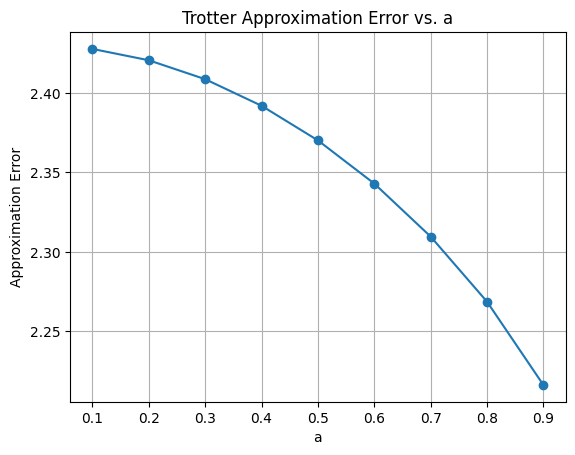

In [2]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

def decompose_hermitian_antihermitian(U):
    """
    Decompose U into its Hermitian (H) and anti-Hermitian (A) parts.
    """
    H = (U + U.conjugate().T) / 2
    A = (U - U.conjugate().T) / 2
    return H, A

def trotter_approximation(U, n_steps=10):
    """
    Approximate U using a Trotter-like expansion of its Hermitian and
    anti-Hermitian parts.
    
    U_approx = ( exp[(H + A)/n_steps] )^n_steps.
    
    Returns the approximation and the norm error.
    """
    H, A = decompose_hermitian_antihermitian(U)
    # Compute the "infinitesimal" update
    U_step = la.expm((H + A) / n_steps)
    U_approx = la.fractional_matrix_power(U_step, n_steps)
    error = np.linalg.norm(U - U_approx)
    return U_approx, error, H, A

# Test for a range of a values
errors = []
a_test = np.linspace(0.1, 0.9, 9)
for a in a_test:
    U = np.array([[np.sqrt(1-a), 0],
                  [np.sqrt(a), 1]], dtype=complex)
    U_approx, error, H, A = trotter_approximation(U, n_steps=10)
    errors.append(error)
    print(f"a = {a:.2f} : Trotter approximation error = {error:.4f}")
    
plt.plot(a_test, errors, marker='o')
plt.xlabel("a")
plt.ylabel("Approximation Error")
plt.title("Trotter Approximation Error vs. a")
plt.grid(True)
plt.show()


The Trotter approximation based on the decomposition of $U$ into its Hermitian and anti-Hermitian parts yielded consistently high errors. For instance, the approximation errors obtained are:
$$
2.4276 \quad (a=0.10),\quad 2.4205 \quad (a=0.20),\quad 2.4086 \quad (a=0.30),\quad 2.3919 \quad (a=0.40),
$$
$$
2.3701 \quad (a=0.50),\quad 2.3429 \quad (a=0.60),\quad 2.3096 \quad (a=0.70),\quad 2.2687 \quad (a=0.80),\quad 2.2163 \quad (a=0.90).
$$

These results indicate that the Trotter approximation does not converge to the desired operator $U$ with sufficient accuracy, as the residual error remains on the order of $\sim 2.2 - 2.4$ across the range of $a$ values. This high error level confirms that the straightforward Hermitian and anti-Hermitian decomposition approach, even when applied with a moderate number of Trotter steps, is unsuitable for accurately implementing the non-unitary operation in our context.

Consequently, these findings reinforce the decision to favor the augmented unitary embedding method proposed by Lin et al. (2021), which, despite its increased resource overhead, more reliably realizes the desired transformation in the quantum circuit.
